Verinin okunması ve eksik veri kontrolü

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression



df = pd.read_csv('Life Expectancy Data.csv')

missing_data = df[df.isnull().any(axis=1)]

print(missing_data)


       Country  Year      Status  Life expectancy   Adult Mortality  \
32     Algeria  2015  Developing              75.6             19.0   
44     Algeria  2003  Developing              71.7            146.0   
45     Algeria  2002  Developing              71.6            145.0   
46     Algeria  2001  Developing              71.4            145.0   
47     Algeria  2000  Developing              71.3            145.0   
...        ...   ...         ...               ...              ...   
2918    Zambia  2003  Developing              46.4             64.0   
2919    Zambia  2002  Developing              45.5             69.0   
2920    Zambia  2001  Developing              44.6            611.0   
2921    Zambia  2000  Developing              43.8            614.0   
2922  Zimbabwe  2015  Developing              67.0            336.0   

      infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   \
32               21      NaN                0.000000         95.0   

Eksik verilerin ısı haritası

Eksik verilerin görselleştirilmesi:


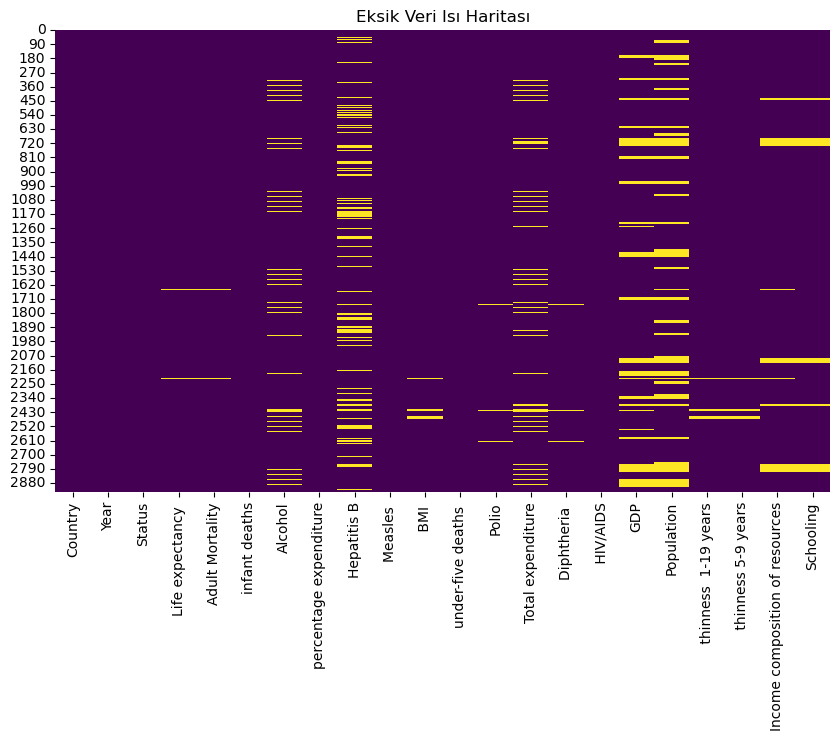

In [2]:
def plot_missing_data(data):
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
    plt.title("Eksik Veri Isı Haritası")
    plt.show()

print("Eksik verilerin görselleştirilmesi:")
plot_missing_data(df)

In [3]:
missing_counts = df.isnull().sum()

print("Her sütundaki eksik veri sayıları:")
print(missing_counts)


Her sütundaki eksik veri sayıları:
Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64


In [4]:
# Compare statistics before and after imputation
print("Veri atama öncesi istatistikler:")
print(df.describe())

Veri atama öncesi istatistikler:
              Year  Life expectancy   Adult Mortality  infant deaths  \
count  2938.000000       2928.000000      2928.000000    2938.000000   
mean   2007.518720         69.224932       164.796448      30.303948   
std       4.613841          9.523867       124.292079     117.926501   
min    2000.000000         36.300000         1.000000       0.000000   
25%    2004.000000         63.100000        74.000000       0.000000   
50%    2008.000000         72.100000       144.000000       3.000000   
75%    2012.000000         75.700000       228.000000      22.000000   
max    2015.000000         89.000000       723.000000    1800.000000   

           Alcohol  percentage expenditure  Hepatitis B       Measles   \
count  2744.000000             2938.000000  2385.000000    2938.000000   
mean      4.602861              738.251295    80.940461    2419.592240   
std       4.052413             1987.914858    25.070016   11467.272489   
min       0.010000    

Veri ataması öncesi performans

In [5]:
df_cleaned = df.dropna()
target_col = 'Life expectancy ' 
if target_col in df_cleaned.columns:
    df_cleaned = df_cleaned.dropna(subset=[target_col])
    features = df_cleaned.drop(columns=[target_col]).select_dtypes(include=[np.number])
    target = df_cleaned[target_col]

    # Veri setini eğitim ve test setlerine ayırın
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Modeli eğitme
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Modeli değerlendirme
    y_pred = model.predict(X_test)
    print("Model performansı:")
    print("Root Mean Squared Error:", mean_squared_error(y_test, y_pred, squared=False))
    print("R-squared:", r2_score(y_test, y_pred))
else:
    print(f"Target column '{target_col}' is not found in the dataset.")

Model performansı:
Root Mean Squared Error: 1.9343283142405614
R-squared: 0.9473177254413783


Verileri standartlaştırma

Kolonları teker teker eksik var mı yok mu kontrol ediyoruz. Eksik olan verileri test, eksik olmayanları train verisi olarak ayırıyoruz. Modeli eğitirken satırlarda herhangi bir eksik olamamsı için eksik satır içeren verileri temizliyoruz. Model eğitilip eksik veriler tamamlanıyor. (Modelin çalışması biraz uzun sürüyor)

In [6]:
df_imputed = df.copy()
numeric_cols = df.select_dtypes(include=[np.number]).columns
    
for col in numeric_cols:
    if df[col].isnull().any():
        # Tam ve eksik vakaları maskele
        missing_mask = df[col].isna()
        complete_mask = ~df[col].isna()
            
        if complete_mask.sum() == 0:
            continue
                
        # Özellikleri hazırlanır (diğer tüm sayısal sütunlar)
        feature_cols = [c for c in numeric_cols if c != col]
            
        # Eksik değerlere sahip her özellik sütunu için, bilinen değerlerin ortalamasını kullanın(geçici olarak)
        temp_df = df[feature_cols].copy()
        for feat_col in feature_cols:
            temp_df[feat_col].fillna(temp_df[feat_col].mean(), inplace=True)
            
        # Özellikleri ve hedefi ölçeklendirin
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
            
        X_train = scaler_X.fit_transform(temp_df[complete_mask])
        y_train = scaler_y.fit_transform(df[complete_mask][[col]])
            
        # GP modelini eğitin
        kernel = C() * RBF()
        gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
        gp.fit(X_train, y_train.ravel())
            
        # Eksik değerleri tahmin edin
        X_missing = scaler_X.transform(temp_df[missing_mask])
        y_pred = gp.predict(X_missing).reshape(-1, 1)
        y_pred = scaler_y.inverse_transform(y_pred)
            
        # Eksik değerleri doldurun
        df_imputed.loc[missing_mask, col] = y_pred

c:\Users\New\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [7]:

missing_counts = df_imputed.isnull().sum()

print("Her sütundaki eksik veri sayıları:")
print(missing_counts)

Her sütundaki eksik veri sayıları:
Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
dtype: int64


Visualizing missing data after imputation:


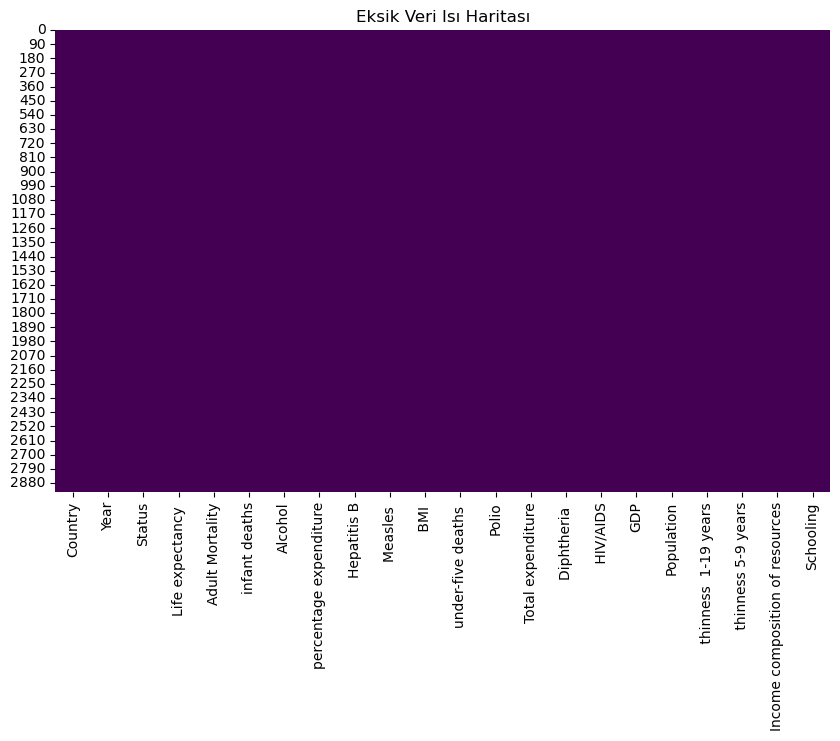

Statistics after imputation:
              Year  Life expectancy   Adult Mortality  infant deaths  \
count  2938.000000       2938.000000      2938.000000    2938.000000   
mean   2007.518720         69.229040       164.796448      30.303948   
std       4.613841          9.509348       124.080302     117.926501   
min    2000.000000         36.300000         1.000000       0.000000   
25%    2004.000000         63.200000        74.000000       0.000000   
50%    2008.000000         72.000000       144.000000       3.000000   
75%    2012.000000         75.600000       227.000000      22.000000   
max    2015.000000         89.000000       723.000000    1800.000000   

           Alcohol  percentage expenditure  Hepatitis B       Measles   \
count  2938.000000             2938.000000  2938.000000    2938.000000   
mean      4.524466              738.251295    80.940461    2419.592240   
std       3.961827             1987.914858    22.586855   11467.272489   
min      -3.233552        

In [8]:

print("Veri atama sonrası ısı haritası:")
plot_missing_data(df_imputed)

# Compare statistics before and after imputation
print("Atama sonrası istatistikler:")
print(df_imputed.describe())


target_col = 'Life expectancy '  
if target_col in df_imputed.columns:
    df_imputed = df_imputed.dropna(subset=[target_col])
    features = df_imputed.drop(columns=[target_col]).select_dtypes(include=[np.number])
    target = df_imputed[target_col]

   
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Train a baseline model (with missing data handled) using Linear Regression
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    print("Model performansı:")
    print("Root Mean Squared Error:", mean_squared_error(y_test, y_pred, squared=False))
    print("R-squared:", r2_score(y_test, y_pred))
else:
    print(f"Target column '{target_col}' is not found in the dataset.")